In [1]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, confusion_matrix,
                            ConfusionMatrixDisplay)
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

import vaex

import numpy as np

import seaborn as sns

In [2]:
def avalia_modelo(modelo, dados_empacotados):
    """Avalia o modelo de classificação com os dados de entrada nas métricas de acurácia, precisao e recall
    
    Args:
        dados_empacotados (array): dados de treino e teste empacotados em um array para facilitar o input
    """
    
    # Desempacotando o input
    x_treino, x_teste, y_treino, y_teste = dados_empacotados
    # Ajustando
    modelo.fit(x_treino, y_treino.ravel())
    
    # Avaliando métricas
    y_pred = modelo.predict(x_teste)
    acuracia = accuracy_score(y_teste, y_pred)
    precisao = precision_score(y_teste, y_pred)
    recall = recall_score(y_teste, y_pred)
    
    # Exibindo as métricas
    print(f'Acurácia: {acuracia*100:.2f}%.')
    print(f'Precisão: {precisao*100:.2f}%.')
    print(f'Recall: {recall*100:.2f}%.')
    # Exibindo a matriz de confusão
    ConfusionMatrixDisplay.from_predictions(y_teste, y_pred)
    
    pass

# 02. Criando uma árvore de decisão

In [3]:
# Carregamento
dados = vaex.from_csv('creditcard.csv')

# Exbibição
print(dados.shape)
dados.head(5)

(284807, 31)


#,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.35981,-0.0727812,2.53635,1.37816,-0.338321,0.462388,0.239599,0.0986979,0.363787,0.0907942,-0.5516,-0.617801,-0.99139,-0.311169,1.46818,-0.470401,0.207971,0.0257906,0.403993,0.251412,-0.0183068,0.277838,-0.110474,0.0669281,0.128539,-0.189115,0.133558,-0.0210531,149.62,0
1,0,1.19186,0.266151,0.16648,0.448154,0.0600176,-0.0823608,-0.078803,0.0851017,-0.255425,-0.166974,1.61273,1.06524,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.0690831,-0.225775,-0.638672,0.101288,-0.339846,0.16717,0.125895,-0.0089831,0.0147242,2.69,0
2,1,-1.35835,-1.34016,1.77321,0.37978,-0.503198,1.8005,0.791461,0.247676,-1.51465,0.207643,0.624501,0.0660837,0.717293,-0.165946,2.34586,-2.89008,1.10997,-0.121359,-2.26186,0.52498,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.0553528,-0.0597518,378.66,0
3,1,-0.966272,-0.185226,1.79299,-0.863291,-0.0103089,1.2472,0.237609,0.377436,-1.38702,-0.0549519,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.05965,-0.684093,1.96578,-1.23262,-0.208038,-0.1083,0.0052736,-0.190321,-1.17558,0.647376,-0.221929,0.0627228,0.0614576,123.5,0
4,2,-1.15823,0.877737,1.54872,0.403034,-0.407193,0.0959215,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.34585,-1.11967,0.175121,-0.451449,-0.237033,-0.0381948,0.803487,0.408542,-0.0094307,0.798278,-0.137458,0.141267,-0.20601,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Checando valores nulos
nulos = []
nulos.extend([dados[col].isna().sum().item() for col in dados.columns])
vaex.from_arrays(coluna=np.array(dados.columns), nulos_ou_NaN=nulos).sort(by='nulos_ou_NaN')

#,coluna,nulos_ou_NaN
0,Time,0
1,V1,0
2,V2,0
3,V3,0
4,V4,0
...,...,...
26,V26,0
27,V27,0
28,V28,0
29,Amount,0


In [5]:
# Checando a quantidade de cada classe
qtds = dados.Class\
    .value_counts()\
    .to_frame(name='porcentagem_da_classe')\
    .rename(index={0: 'legitimo', 1: 'fraude'})

qtds.porcentagem_da_classe = round(qtds.porcentagem_da_classe*100/dados.shape[0], 2).astype('str') + '%'

display(qtds)

,porcentagem_da_classe
legitimo,99.83%
fraude,0.17%


Como os casos de fraude são uma minoria esmagadora, o dataset precisa ser dividido de forma que tanto os dados de teste e treino contemplem casos de fraude, de forma a não enviesar o aprendizado ou a acurácia do classificador.

In [6]:
# Atribuindo features (x) e target (y)
x = dados.drop('Class').values
y = dados[['Class']].values

In [7]:
# Dividindo os dados de forma estratificada
strat = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=333)

for tr_id, tst_id in strat.split(x, y):
    # Treino
    x_treino = x[tr_id]
    y_treino = y[tr_id]
    # Teste
    x_teste = x[tst_id]
    y_teste = y[tst_id]
    
dados_empacotados = [x_treino, x_teste, y_treino, y_teste]

Acurácia: 99.88%.
Precisão: 61.67%.
Recall: 75.51%.
Wall time: 21.6 s


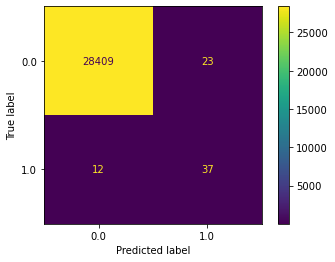

In [8]:
%%time
# Performance da árvore com parâmetros padrão
avalia_modelo(DecisionTreeClassifier(random_state=333), dados_empacotados)

# 03. Avaliando a árvore de decisão

O índice de precisão, assim como a matriz de confusão, mostram como o modelo erra (relativamente) bastante nos casos de fraude em si e, nesse caso, o pior erro é deixar um caso fraudulento se passar por legítimo. Alguma mudança na forma como a classificação pode ser feita por meio dos hiperparâmetros do estimador.

Acurácia: 99.95%.
Precisão: 92.50%.
Recall: 75.51%.


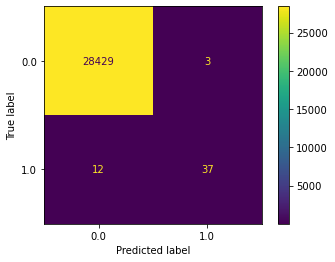

In [9]:
# Limitando o valor de max_depth
modelo = DecisionTreeClassifier(max_depth=10, random_state=333)
avalia_modelo(modelo, dados_empacotados)

Acurácia: 99.95%.
Precisão: 92.68%.
Recall: 77.55%.


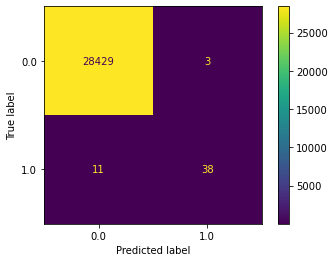

In [10]:
# Atribuindo min_samples_leaf
modelo = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=333)
avalia_modelo(modelo, dados_empacotados)

# 04. Aprendendo ensemble learning com bagging

Acurácia: 99.96%.
Precisão: 97.44%.
Recall: 77.55%.
Wall time: 4min 8s


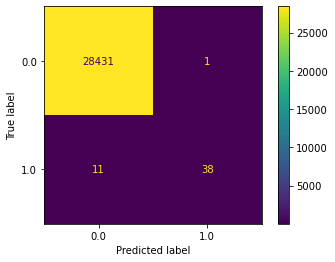

In [11]:
%%time
# Usando o modelo de random forest para aplicar bagging
modelo = RandomForestClassifier(random_state=333)
avalia_modelo(modelo, dados_empacotados)

Acurácia: 99.95%.
Precisão: 95.00%.
Recall: 77.55%.
Wall time: 1min 12s


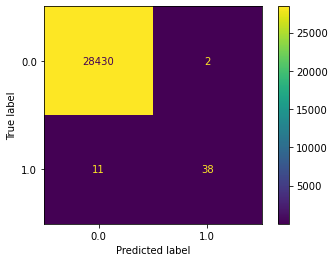

In [12]:
%%time
# Diminuindo max_depth e n_estimators (padrão é 100)
modelo = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=333)
avalia_modelo(modelo, dados_empacotados)

# 05. Aprendendo ensemble learning com boosting

Acurácia: 99.93%.
Precisão: 83.72%.
Recall: 73.47%.
Wall time: 1min 12s


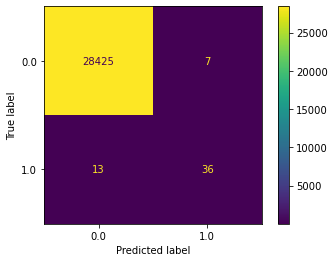

In [13]:
%%time
# Usando o Adaboost para aplicar o boosting
modelo = AdaBoostClassifier(random_state=333)
avalia_modelo(modelo, dados_empacotados)

Acurácia: 99.93%.
Precisão: 82.61%.
Recall: 77.55%.
Wall time: 2min 24s


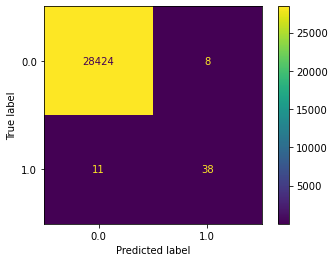

In [14]:
%%time
# Mudando max_depth
modelo = AdaBoostClassifier(n_estimators=100, random_state=333)
avalia_modelo(modelo, dados_empacotados)